In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pakistans-largest-ecommerce-dataset/Pakistan Largest Ecommerce Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
dataset=pd.read_csv("../input/../input/pakistans-largest-ecommerce-dataset/Pakistan Largest Ecommerce Dataset.csv", low_memory=False)

In [4]:
print('Dataframe dimensions:', dataset.shape)

Dataframe dimensions: (1048575, 26)


In [5]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(dataset.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()/dataset.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(dataset[:5])

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,Month,Customer Since,M-Y,FY,Customer ID,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
column type,float64,object,object,object,float64,float64,float64,object,object,object,...,float64,object,object,object,float64,float64,float64,float64,float64,float64
null values (nb),464051,464066,464051,464071,464051,464051,464051,464051,464215,601226,...,464051,464062,464051,464051,464062,1048575,1048575,1048575,1048575,1048575
null values (%),44.255394,44.256825,44.255394,44.257302,44.255394,44.255394,44.255394,44.255394,44.271034,57.337434,...,44.255394,44.256443,44.255394,44.255394,44.256443,100.0,100.0,100.0,100.0,100.0


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,Month,Customer Since,M-Y,FY,Customer ID,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,211131.0,complete,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,\N,...,7.0,2016-7,7-2016,FY17,1.0,NaN,NaN,NaN,NaN,NaN
1,211133.0,canceled,7/1/2016,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,240.0,1.0,240.0,100147444,Beauty & Grooming,\N,...,7.0,2016-7,7-2016,FY17,2.0,NaN,NaN,NaN,NaN,NaN
2,211134.0,canceled,7/1/2016,Ego_UP0017-999-MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,\N,...,7.0,2016-7,7-2016,FY17,3.0,NaN,NaN,NaN,NaN,NaN
3,211135.0,complete,7/1/2016,kcc_krone deal,360.0,1.0,60.0,100147446,Beauty & Grooming,R-FSD-52352,...,7.0,2016-7,7-2016,FY17,4.0,NaN,NaN,NaN,NaN,NaN
4,211136.0,order_refunded,7/1/2016,BK7010400AG,555.0,2.0,1110.0,100147447,Soghaat,\N,...,7.0,2016-7,7-2016,FY17,5.0,NaN,NaN,NaN,NaN,NaN


In [6]:
dataset = dataset.dropna(axis=1, how='all')
#to remove the extra NaN values generated by pandas in dummy columns as it was because of column so axis=1 is selected and to drop only those column which has all NaN values all is used

In [7]:
dataset.shape #Confirming if the extra columns are gone

(1048575, 21)

In [8]:
#Repeating previous step to check Null values scenerio
tab_info=pd.DataFrame(dataset.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()/dataset.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
column type,float64,object,object,object,float64,float64,float64,object,object,object,...,object,object,object,object,float64,float64,object,object,object,float64
null values (nb),464051,464066,464051,464071,464051,464051,464051,464051,464215,601226,...,464051,464051,464051,464051,464051,464051,464062,464051,464051,464062
null values (%),44.255394,44.256825,44.255394,44.257302,44.255394,44.255394,44.255394,44.255394,44.271034,57.337434,...,44.255394,44.255394,44.255394,44.255394,44.255394,44.255394,44.256443,44.255394,44.255394,44.256443


In [9]:
dataset.dropna(axis = 0, subset = ['Customer ID'], inplace = True)
print('Dataframe dimensions:', dataset.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(dataset.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(dataset.isnull().sum()/dataset.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (584513, 21)


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
column type,float64,object,object,object,float64,float64,float64,object,object,object,...,object,object,object,object,float64,float64,object,object,object,float64
null values (nb),0,15,0,20,0,0,0,0,164,137164,...,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.002566,0.0,0.003422,0.0,0.0,0.0,0.0,0.028058,23.466373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print('Duplicate Entries {}'.format(dataset.duplicated().sum()))
dataset.drop_duplicates(inplace = True)

Duplicate Entries 0


In [11]:
pd.DataFrame([{'products': len(dataset['sku'].value_counts()),    
               'transactions': len(dataset['increment_id'].value_counts()),
               'customers': len(dataset['Customer ID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,84888,408773,115326


In [12]:
temp = dataset.groupby(by=['Customer ID', 'increment_id',"status"], as_index=False)['M-Y'].count()
nb_products_per_basket = temp.rename(columns = {'M-Y':'Number of products'})
nb_products_per_basket[:10].sort_values('Customer ID')

,Customer ID,increment_id,status,Number of products
0,1.0,100147443,complete,1
1,2.0,100147444,canceled,1
2,2.0,100222998,canceled,1
3,3.0,100147445,canceled,1
4,3.0,100306394,complete,4
5,4.0,100147446,complete,1
6,4.0,100148389,complete,1
7,4.0,100149432,complete,1
8,4.0,100150135,complete,1
9,4.0,100151149,complete,1


In [13]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket.status == 'canceled'
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))


,Customer ID,increment_id,status,Number of products,order_canceled
0,1.0,100147443,complete,1,False
1,2.0,100147444,canceled,1,True
2,2.0,100222998,canceled,1,True
3,3.0,100147445,canceled,1,True
4,3.0,100306394,complete,4,False


Number of orders canceled: 148651/408762 (36.37%) 


I am not able to resolve this one

In [14]:
dataset[dataset["status"]=="canceled"].count()

item_id                  201244
status                   201244
created_at               201244
sku                      201235
price                    201244
qty_ordered              201244
grand_total              201244
increment_id             201244
category_name_1          201136
sales_commission_code    141446
discount_amount          201244
payment_method           201244
Working Date             201244
BI Status                201244
 MV                      201244
Year                     201244
Month                    201244
Customer Since           201244
M-Y                      201244
FY                       201244
Customer ID              201244
dtype: int64

In [15]:
dataset.describe() #To find description of numerical data (statistcal analysis)

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,584513.000000,5.845130e+05,584513.000000,5.845130e+05,584513.000000,584513.000000,584513.000000,584513.000000
mean,565663.128495,6.348821e+03,1.296375,8.530676e+03,499.502175,2017.044097,7.167746,45790.511965
std,200120.929873,1.494940e+04,3.996094,6.132138e+04,1506.955668,0.707349,3.486270,34414.962389
min,211131.000000,0.000000e+00,1.000000,-1.594000e+03,-599.500000,2016.000000,1.000000,1.000000
25%,394997.000000,3.600000e+02,1.000000,9.450000e+02,0.000000,2017.000000,4.000000,13516.000000
50%,568417.000000,8.990000e+02,1.000000,1.960400e+03,0.000000,2017.000000,7.000000,42856.000000
75%,739102.000000,4.070000e+03,1.000000,6.999000e+03,160.520000,2018.000000,11.000000,73536.000000
max,905208.000000,1.012626e+06,1000.000000,1.788800e+07,90300.000000,2018.000000,12.000000,115326.000000


Text(0, 0.5, 'Count')

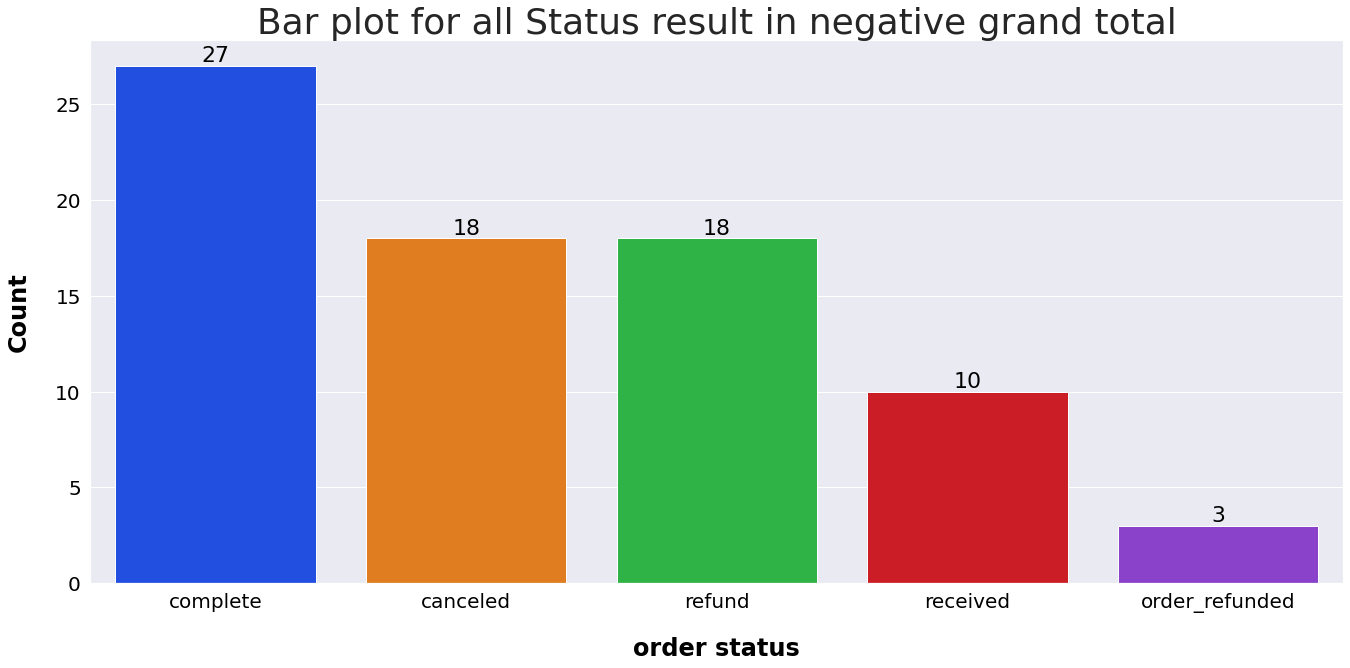

In [16]:
#To investigate the negatve value in grand total minimum
gt = dataset[dataset.grand_total < 0].status.value_counts().to_dict() #checked the less than 0 i.e negative values, count them and convert the data set into dictionary
gt_df = pd.DataFrame(list(gt.items()), columns=["Order Status","Count"])

#Defining the figure size
plt.figure(figsize=(20,10))

#Creating a Bar Chart
sns.set(font_scale = 3)
ax = sns.barplot(data=gt_df, x = "Order Status", y="Count", palette = "bright")
ax.set(title='Bar plot for all Status result in negative grand total')
ax.bar_label(container = ax.containers[0],padding = 0, fontsize = 22, color ="black")


#Setting up axis label size and colours of axis label
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.tick_params(axis="x",colors = "black")
ax.tick_params(axis="y",colors = "black")

#setting up axis label name and size
plt.xlabel("order status",fontsize=24,labelpad=24,color = "black", fontweight='bold')
plt.ylabel("Count",fontsize=24,labelpad=24,color = "black",fontweight='bold')



# it was giving error: AttributeError: 'AxesSubplot' object has no attribute 'bar_label' so updating matplotlib in 1st cell and removed that cell to avoid updating check again and again

In [17]:
dataset = dataset[dataset.grand_total > 0] #got rid of negative values

In [18]:
dataset.describe() #checking the impact of removing negative values, now min grand_total has positive value

,item_id,price,qty_ordered,grand_total,discount_amount,Year,Month,Customer ID
count,574805.000000,5.748050e+05,574805.000000,5.748050e+05,574805.000000,574805.000000,574805.000000,574805.000000
mean,565521.827281,6.401348e+03,1.298030,8.674791e+03,497.636419,2017.042552,7.181293,45787.779259
std,200135.939153,1.500883e+04,4.006866,6.182694e+04,1499.875464,0.707230,3.486686,34389.306168
min,211131.000000,0.000000e+00,1.000000,2.100000e-01,-599.500000,2016.000000,1.000000,1.000000
25%,394726.000000,3.600000e+02,1.000000,9.936500e+02,0.000000,2017.000000,4.000000,13575.000000
50%,568598.000000,9.000000e+02,1.000000,1.999000e+03,0.000000,2017.000000,7.000000,42846.000000
75%,738525.000000,4.312000e+03,1.000000,7.220800e+03,162.000000,2018.000000,11.000000,73512.000000
max,905208.000000,1.012626e+06,1000.000000,1.788800e+07,90300.000000,2018.000000,12.000000,115326.000000


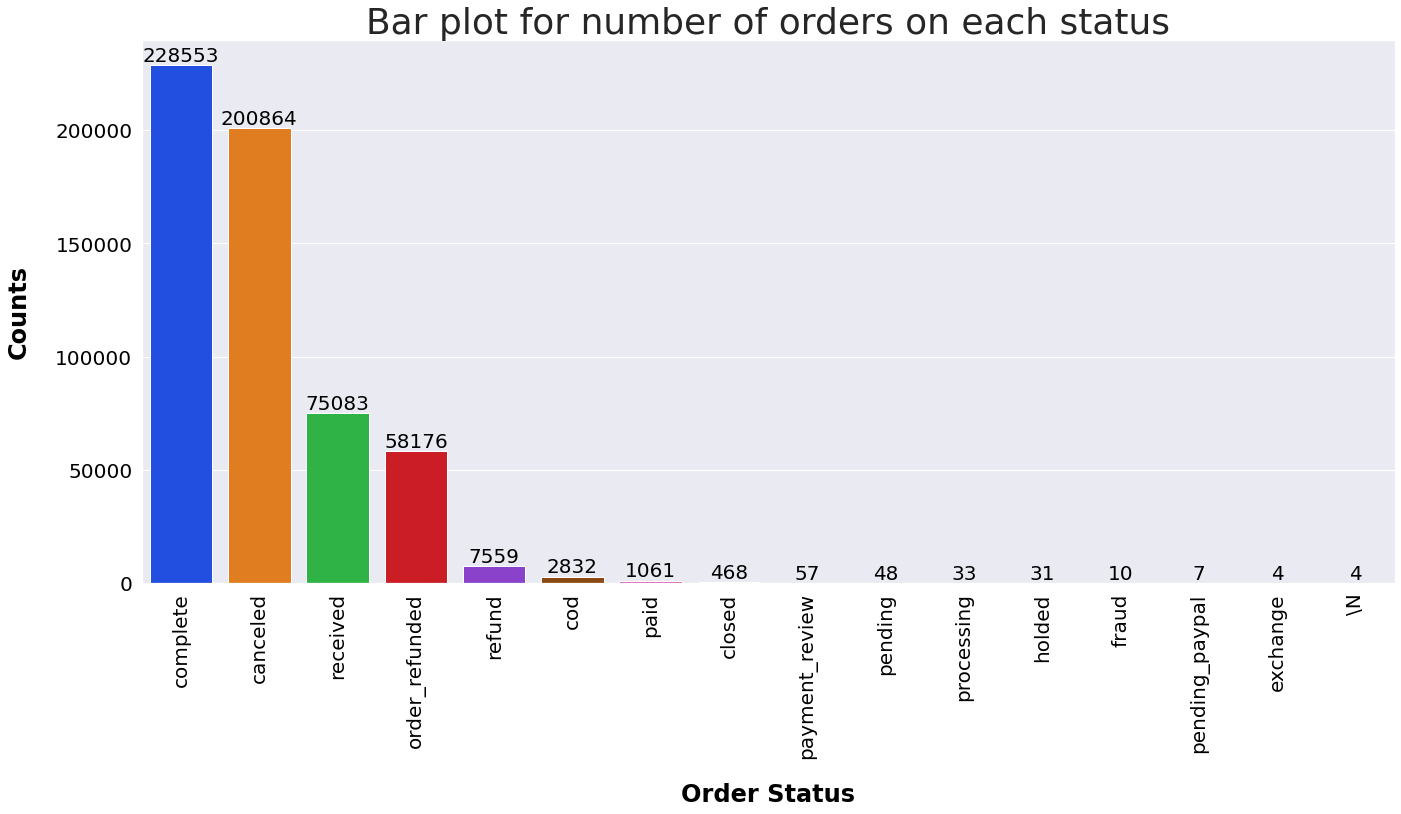

In [19]:
plt.figure(figsize=(20,10))

orderstatus = dataset.status.value_counts()
orderstatus_df = pd.DataFrame(list(orderstatus.items()), columns=['Order Status', 'Counts'])

#Creating a Bar Chart
sns.set(font_scale = 3)
ax = sns.barplot(data = orderstatus_df, x= 'Order Status', y = "Counts", palette = "bright") 
ax.bar_label(container = ax.containers[0], padding = 0, fontsize = 20, color='black')
ax.set(title='Bar plot for number of orders on each status')

#Setting up axis label size and colours of axis label
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black');

#setting up axis label name and size
plt.xlabel('Order Status', fontsize=24, labelpad=24, color='black',fontweight='bold')
plt.ylabel('Counts', fontsize=24, labelpad=24, color='black',fontweight='bold');

#setting up x axis labels verticaly and horizontalalignment to center
plt.xticks(rotation=90, ha='center');


In [20]:
#orders with the status like complete, cod, paid, received, exchanged are completed orders in our point of view in handling this data so we will group them under completed. 
#Orders with cancelled, order refunded, refund and fraud statuses are grouped under cancelled
#Orders with status like payment_review, pending, processing, holded and pending paypal are all grouped under pending

dataset.status = dataset.status.replace({'complete': 'Completed',
                                             'received': 'Completed',
                                             'cod': 'Completed',
                                             'paid': 'Completed',
                                             'closed': 'Completed',
                                             'exchange': 'Completed',
                                             'canceled': 'Canceled',
                                             'order_refunded': 'Canceled',
                                             'refund': 'Canceled',
                                             'fraud': 'Canceled',
                                             'payment_review': 'Pending',
                                             'pending': 'Pending',
                                             'processing': 'Pending',
                                             'holded': 'Pending',
                                             'pending_paypal': 'Pending'})

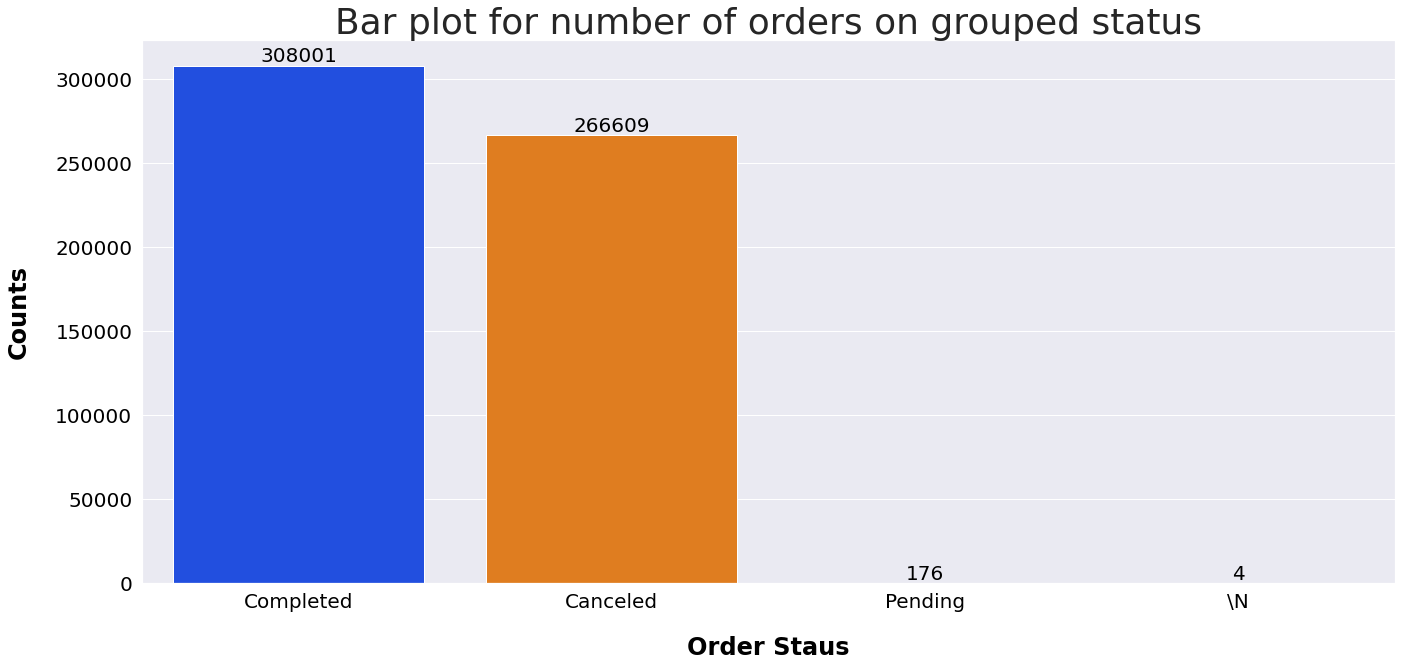

In [21]:
status_updated = dataset.status.value_counts()

status_updated_df = pd.DataFrame(list(status_updated.items()), columns=['Order Status', 'Counts'])

plt.figure(figsize=(20,10))

#Creating a Bar Chart
sns.set(font_scale = 3)
ax = sns.barplot(data=status_updated_df, x='Order Status', y='Counts', palette='bright')
ax.bar_label(container = ax.containers[0], padding = 0, fontsize = 20, color='black')
ax.set(title='Bar plot for number of orders on grouped status')


#Setting up axis label size and colours of axis label
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black');

#setting up axis label name and size

plt.xlabel('Order Staus', fontsize=24, labelpad=24, color='black', fontweight='bold')
plt.ylabel('Counts', fontsize=24, labelpad=24, color='black', fontweight='bold');



In [22]:
#Saving cancelled orders seperately 
canceled = dataset[dataset.status == 'Canceled']

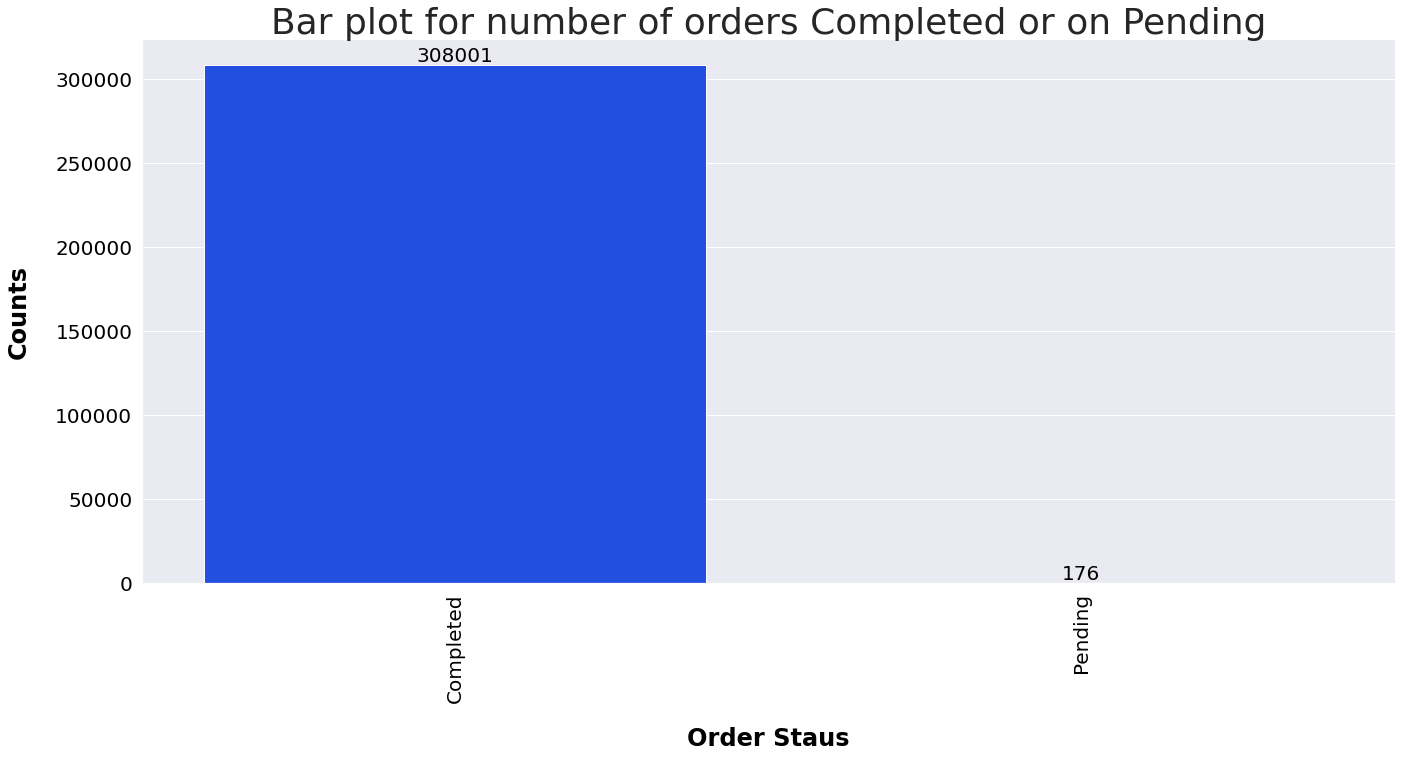

In [23]:
dataset = dataset[(dataset.status == 'Completed') | (dataset.status == 'Pending')]
status_updated = dataset.status.value_counts()

status_updated_df = pd.DataFrame(list(status_updated.items()), columns=['Order Status', 'Counts'])

plt.figure(figsize=(20,10))

#Creating a Bar Chart
sns.set(font_scale = 3)
ax = sns.barplot(data=status_updated_df, x='Order Status', y='Counts', palette='bright')
ax.bar_label(container = ax.containers[0], padding = 0, fontsize = 20, color='black')
ax.set(title='Bar plot for number of orders Completed or on Pending')


#Setting up axis label size and colours of axis label
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black');

#setting up axis label name and size
plt.xlabel('Order Staus', fontsize=24, labelpad=24, color='black', fontweight='bold')
plt.ylabel('Counts', fontsize=24, labelpad=24, color='black', fontweight='bold');

#setting up x axis labels verticaly and horizontalalignment to center
plt.xticks(rotation=90, ha='center');


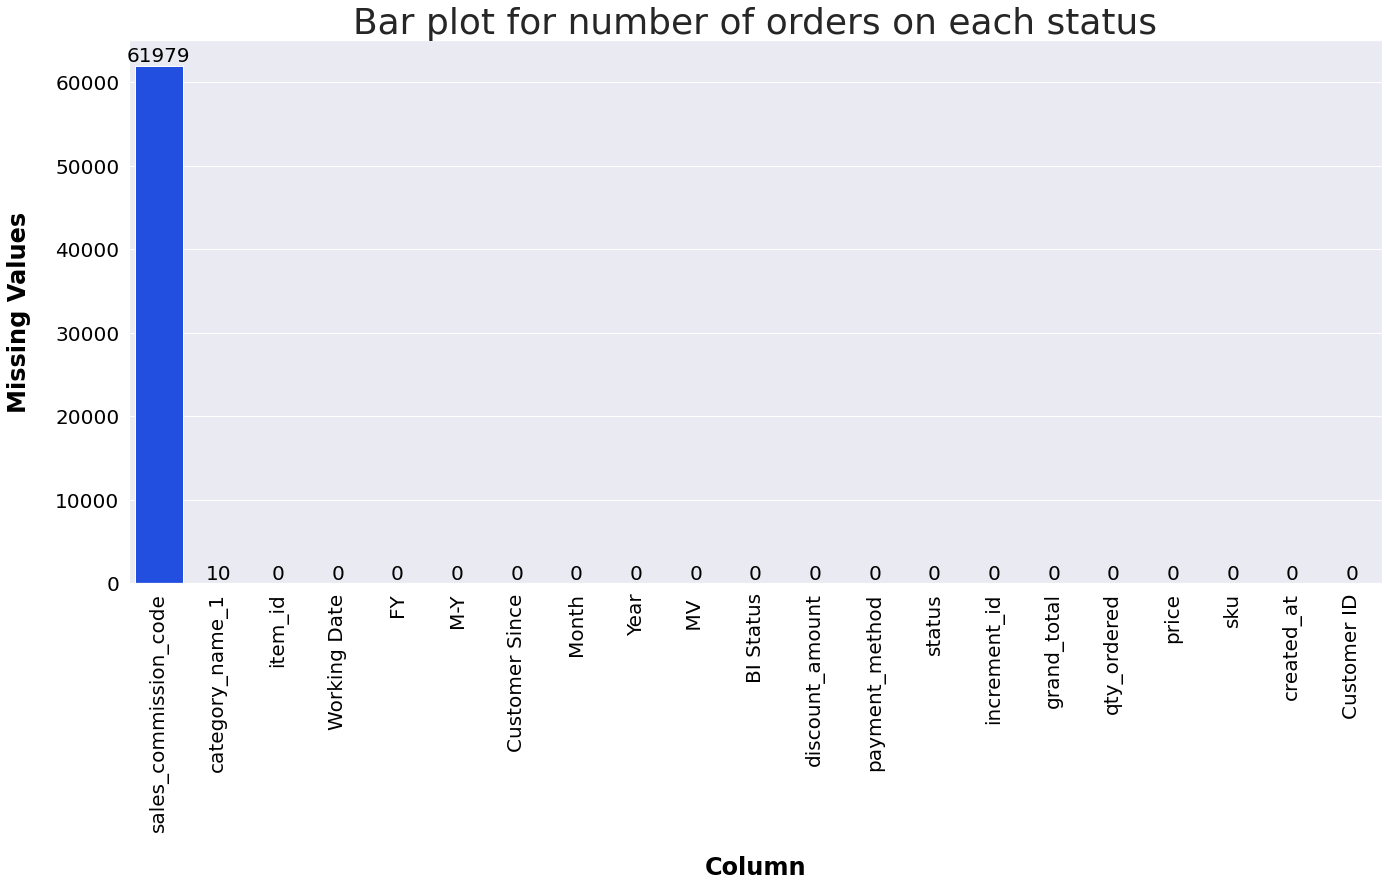

In [24]:
#Sorting out missing values
missing_values = dataset.isna().sum().sort_values(ascending=False)

missing_values_df = pd.DataFrame(list(missing_values.items()), columns=['Column', 'Missing_Values'])

plt.figure(figsize=(20,10))

#Creating a Bar Chart
sns.set(font_scale = 3)
ax = sns.barplot(data=missing_values_df, x = 'Column', y = 'Missing_Values', palette='bright')
ax.bar_label(container = ax.containers[0], padding = 0, fontsize = 20, color='black')
ax.set(title='Bar plot for number of orders on each status')


#Setting up axis label size and colours of axis label
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black');

#setting up axis label name and size
ax.set_xlabel('Column', fontsize=24, labelpad=24, color='black', fontweight='bold')
ax.set_ylabel('Missing Values', fontsize=24, labelpad=24, color='black', fontweight='bold');

#setting up x axis labels verticaly and horizontalalignment to center
plt.xticks(rotation=90, ha='center');


In [25]:
#In the above graph it is cleared that majorly missing values are in the sales commision column which is understandalbe. Anyways we dont need commsion code



dataset = dataset.drop(columns=['sales_commission_code'])
dataset=dataset.dropna()
dataset.shape

(308167, 20)

In [26]:
#checking how data looks now
dataset.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
0,211131.0,Completed,7/1/2016,kreations_YI 06-L,1950.0,1.0,1950.0,100147443,Women's Fashion,0.0,cod,7/1/2016,#REF!,"1,950",2016.0,7.0,2016-7,7-2016,FY17,1.0
3,211135.0,Completed,7/1/2016,kcc_krone deal,360.0,1.0,60.0,100147446,Beauty & Grooming,300.0,cod,7/1/2016,Net,360,2016.0,7.0,2016-7,7-2016,FY17,4.0
6,211138.0,Completed,7/1/2016,kcc_krone deal,360.0,1.0,60.0,100147449,Beauty & Grooming,300.0,cod,7/1/2016,Net,360,2016.0,7.0,2016-7,7-2016,FY17,7.0
7,211139.0,Completed,7/1/2016,UK_Namkino Mix Nimco 400 Gms,170.0,1.0,170.0,100147450,Soghaat,0.0,cod,7/1/2016,Net,170,2016.0,7.0,2016-7,7-2016,FY17,6.0
10,211142.0,Completed,7/1/2016,"GFC_Pedestal Myga Cross Base (Special Guard) 24""",5500.0,1.0,5500.0,100147453,Appliances,0.0,cod,7/1/2016,Net,"5,500",2016.0,7.0,2016-7,7-2016,FY17,9.0


In [27]:
#Number of Orders vs number of customers

num_of_orders = dataset.groupby("Customer ID")["increment_id"].nunique().sort_values(ascending=False) #Grouping Customers with increment ids and counting unique values
num_of_orders_df = pd.DataFrame(list(num_of_orders.items()),columns = ["Customer ID","Number of Orders"])

x = num_of_orders_df[num_of_orders_df["Number of Orders"] == 1].value_counts().sum()
y = num_of_orders_df[num_of_orders_df["Number of Orders"] != 1].value_counts().sum()


data = {"order" : ["Customers with Single orders", "Customers with Multiple orders"], "Customer_Counts": [x,y]}

order_counts = pd.DataFrame.from_dict(data)

import plotly.express as px #Needed this to create piechart 

#Creating a pie chart
fig = px.pie(order_counts, 
             values = order_counts.Customer_Counts, 
             names = order_counts.order,
             template = 'plotly_white')

#Setting up the pie chart cosmetics
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=18,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

In [28]:
#Number of Orders vs Categories

num_of_prod = dataset.groupby('Customer ID')['category_name_1'].nunique().sort_values(ascending=False) #Grouping Customers with categories and counting unique values

num_of_prod_df = pd.DataFrame(list(num_of_prod.items()), columns=['Customer ID', 'Number of Products'])

a = num_of_prod_df[num_of_prod_df['Number of Products'] == 1].value_counts().sum()
b = num_of_prod_df[num_of_prod_df['Number of Products'] != 1].value_counts().sum()

data = {'Order': ['One Category', 'More than One Category'], 'Customer_Counts': [a, b]}

category_counts = pd.DataFrame.from_dict(data)


#Creating a pie chart
fig = px.pie(category_counts, 
             values = category_counts.Customer_Counts, 
             names = category_counts.Order,
             template = 'plotly_white')

#Setting up the pie chart cosmetics
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=18,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()


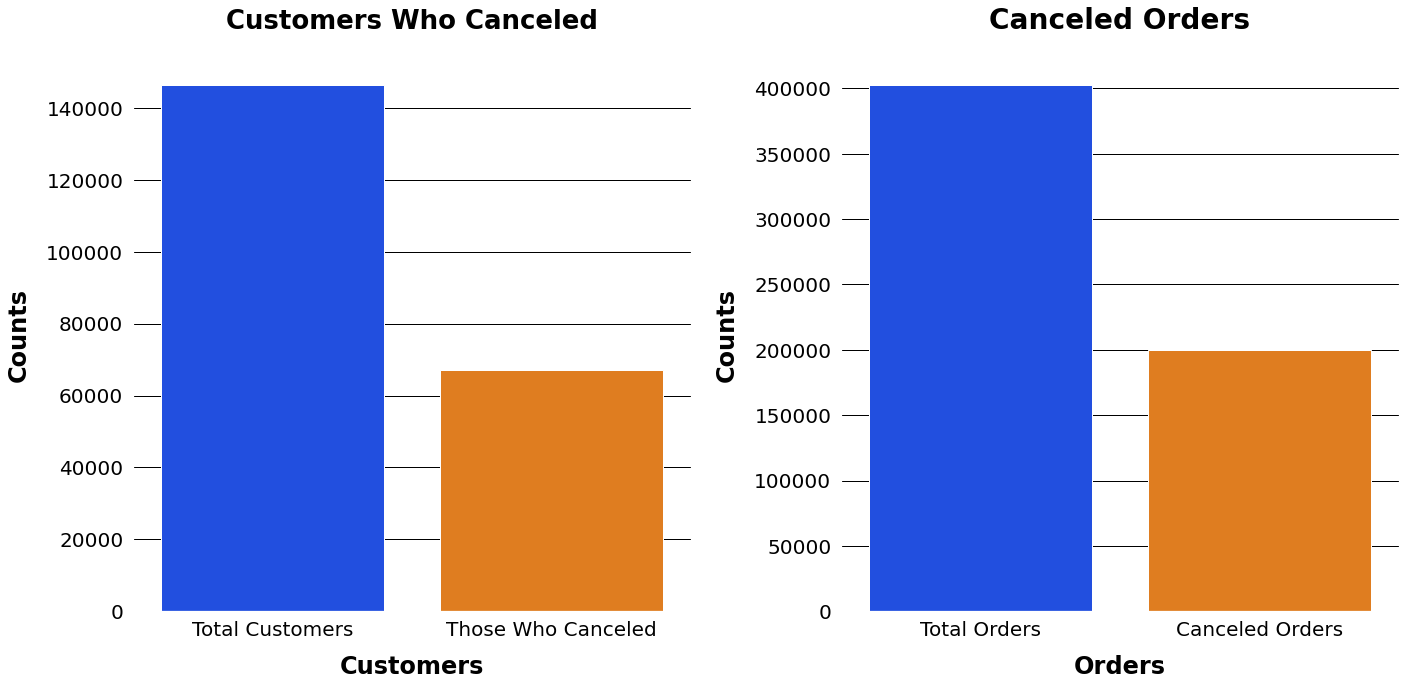

In [29]:
a = dataset['Customer ID'].nunique() + canceled ['Customer ID'].nunique()
b = canceled ['Customer ID'].nunique()

data = {'Customers': ['Total Customers', 'Those Who Canceled'], 'Customer_Counts': [a, b]}

customer_counts = pd.DataFrame.from_dict(data)


c = dataset['increment_id'].nunique() + canceled['increment_id'].nunique()
d = canceled ['increment_id'].nunique()

data = {'Orders': ['Total Orders', 'Canceled Orders'], 'Order_Counts': [c, d]}

order_counts = pd.DataFrame.from_dict(data)

#Setting up background colour of figures, and grid
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.grid' : True,"grid.color": "black"})

#Creating 2 bar plots one for customer who cancelled and the orders which got cancelled
fig, ax = plt.subplots(1,2, figsize = (20,10))
sns.barplot(ax = ax[0], data = customer_counts, x=customer_counts.Customers, y=customer_counts.Customer_Counts, palette= 'bright')
sns.barplot(ax = ax[1], data = order_counts, x=order_counts.Orders, y=order_counts.Order_Counts, palette= 'bright')

#Setting 1st barchart cosmetics
ax[0].set_title("Customers Who Canceled", fontsize = 26, pad = 30, color='black', fontweight='bold')
ax[0].set_xlabel("Customers", fontsize = 24, labelpad = 15, color='black', fontweight='bold')
ax[0].set_ylabel("Counts", fontsize = 24, labelpad = 15, color='black', fontweight='bold')
ax[0].tick_params(axis='x', colors='black', labelsize=20)
ax[0].tick_params(axis='y', colors='black', labelsize=20)

#Setting 2nd barchart cosmetics
ax[1].set_title("Canceled Orders", fontsize = 28, pad = 30, color='black', fontweight='bold')
ax[1].set_xlabel("Orders", fontsize = 24, labelpad = 15, color='black', fontweight='bold')
ax[1].set_ylabel("Counts", fontsize = 24, labelpad = 15, color='black', fontweight='bold')
ax[1].tick_params(axis='x', colors='black', labelsize=20)
ax[1].tick_params(axis='y', colors='black', labelsize=20);

plt.tight_layout(pad=2);


In [30]:
#Finding Categories whose orders got cancelled most

canceled = canceled.dropna() #Dropping NaN values


fig = px.treemap(canceled, 
                 path=['category_name_1'], template='seaborn',width=1000, height=1000)
fig.update_traces(textfont_color='black',textfont_size=20, selector=dict(type='treemap'))
fig.show()

In [31]:
#Total categories in a dataset
category=dataset["category_name_1"].unique()
print("All categories in the dataset =",category)

n=dataset["category_name_1"].nunique()
print("number of categories n =",n)

All categories in the dataset = ["Women's Fashion" 'Beauty & Grooming' 'Soghaat' 'Appliances'
 'Home & Living' 'Kids & Baby' 'Mobiles & Tablets' '\\N' "Men's Fashion"
 'Superstore' 'Others' 'Health & Sports' 'Computing' 'Books'
 'School & Education' 'Entertainment']
number of categories n = 16


In [32]:
#Exploring category //N 
dataset[dataset["category_name_1"]=="\\N"]

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,discount_amount,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
99,211242.0,Completed,7/1/2016,urban_ PT004-L,550.0,1.0,550.00,100147518,\N,0.0,cod,7/1/2016,Net,550,2016.0,7.0,2016-7,7-2016,FY17,47.0
361,211524.0,Completed,7/1/2016,WE_ni72_parrot-veet-gift,1330.0,1.0,1330.00,100147732,\N,0.0,marketingexpense,7/1/2016,Net,"1,330",2016.0,7.0,2016-7,7-2016,FY17,116.0
483,211660.0,Completed,7/1/2016,E TCF_Educate a child for a month-PKR 1250,1250.0,1.0,994.00,100147840,\N,0.0,cod,7/1/2016,Net,"1,250",2016.0,7.0,2016-7,7-2016,FY17,16.0
768,212023.0,Completed,7/2/2016,Gasonline-MPT-524-BEIGE-36,1099.0,1.0,1099.00,100148063,\N,0.0,cod,7/2/2016,Net,"1,099",2016.0,7.0,2016-7,7-2016,FY17,284.0
793,212055.0,Completed,7/2/2016,Gasonline-MPT-560-GREY-30,1099.0,1.0,1099.00,100148078,\N,0.0,cod,7/2/2016,Net,"1,099",2016.0,7.0,2016-7,7-2016,FY17,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389624,682965.0,Completed,11/24/2017,OTHOTH5A0945D0A72F4,90.0,2.0,1308.75,100418767,\N,0.0,cod,11/24/2017,Valid,180,2017.0,11.0,2017-11,11-2017,FY18,78466.0
412385,709595.0,Completed,12/6/2017,OTHOTH5A0945D0A72F4,90.0,1.0,1185.00,100433636,\N,0.0,Easypay,12/6/2017,Valid,90,2017.0,12.0,2017-11,12-2017,FY18,71907.0
422952,721912.0,Completed,12/26/2017,OTHOTH5A2F72DBBB0C9,100.0,1.0,250.00,100440407,\N,0.0,cod,12/26/2017,Valid,100,2017.0,12.0,2017-8,12-2017,FY18,59587.0
423231,722242.0,Completed,12/27/2017,MEFQMO59B0942707B79-L,99.0,1.0,249.00,100440593,\N,0.0,cod,12/27/2017,Valid,99,2017.0,12.0,2017-11,12-2017,FY18,66884.0


In [33]:
#it seems it is just like others category so we will merge both under others
dataset["category_name_1"]=dataset["category_name_1"].replace(['\\N'], "Others")

In [34]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'sku'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [35]:
df_produits = pd.DataFrame(dataset['sku'].unique()).rename(columns = {0:'sku'})

In [36]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'sku': 58280


In [37]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

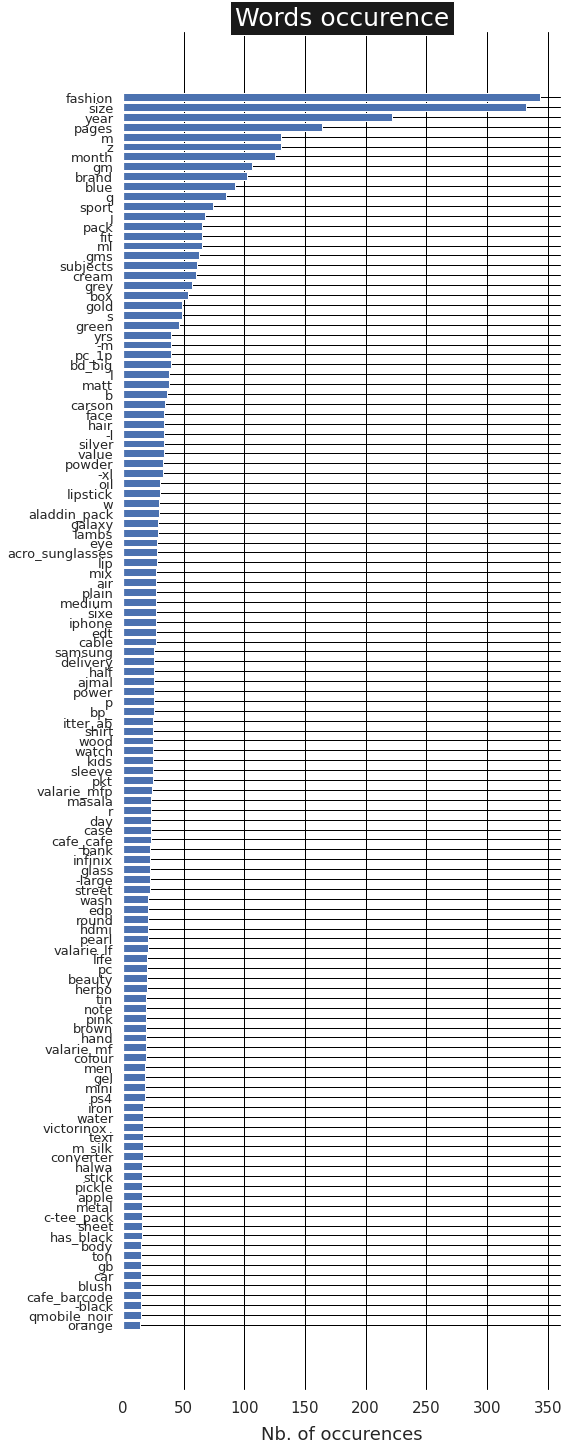

In [38]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [39]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 126


In [40]:
liste_produits = dataset['sku'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [41]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = dataset[ dataset['sku'] == prod]['price'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [42]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       15                  
1<.<2       11                  
2<.<3       1                   
3<.<5       13                  
5<.<10      13                  
.>10        62478               
